In [ ]:
##@Author: Gemma Gordon
##@Date: March 2023
# Script to analyse characteristics of the antigens included in the Abs and sdAbs datasets: size, concavity vs deposition date

Analyse antigens of sdAbs and Abs datasets 

Compare antigen size for sdAbs vs Abs sets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.dpi'] = 1200

Already have csv of structure and which are Ag chains 

In [3]:
abs_summary = pd.read_csv('Dataset_flAbs_summary.csv')
sdabs_summary = pd.read_csv('Dataset_sdAbs_summary.csv')

In [4]:
abs_ag_sequences = abs_summary['antigen_sequence']
sdabs_ag_sequences = sdabs_summary['antigen_sequence']

In [5]:
abs_ag_sizes = [len(a) for a in abs_ag_sequences]
sdabs_ag_sizes = [len(s) for s in sdabs_ag_sequences]

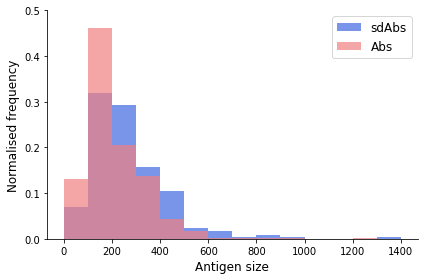

In [20]:
bins = np.arange(0, 1500, 100)
plt.figure()
plt.hist(sdabs_ag_sizes, bins=bins, label='sdAbs', alpha=0.7, color='royalblue', weights=np.zeros_like(sdabs_ag_sizes) + 1. / len(sdabs_ag_sizes))
plt.hist(abs_ag_sizes, bins=bins, label='Abs', alpha=0.7, color='lightcoral', weights=np.zeros_like(abs_ag_sizes) + 1. / len(abs_ag_sizes))
plt.xlabel('Antigen size', fontsize=12)
plt.ylim(0, 0.5, 0.1)
plt.ylabel('Normalised frequency', fontsize=12)
plt.legend(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [21]:
pd.Series(abs_ag_sizes).describe()

count     892.000000
mean      210.528027
std       120.077614
min        51.000000
25%       120.750000
50%       193.000000
75%       262.250000
max      1267.000000
dtype: float64

In [22]:
pd.Series(sdabs_ag_sizes).describe()

count     345.000000
mean      267.011594
std       155.186740
min        63.000000
25%       159.000000
50%       245.000000
75%       338.000000
max      1334.000000
dtype: float64

#### bootstrapping 

In [23]:
%pip install statsmodels

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import dabest
from statsmodels.stats.weightstats import ztest as ztest

In [25]:
def perform_bootstrap(n_sample, interaction_sizes):
    df = pd.DataFrame([np.random.choice(interaction_sizes[k],n_sample,replace=False) for k in interaction_sizes]).T
    df.columns = [k for k in interaction_sizes]
    x = dabest.load(df, idx=(list(interaction_sizes.keys())[0],list(interaction_sizes.keys())[1]))
    print(x.mean_diff)

In [26]:
zoutput_agsize = ztest(pd.Series(sdabs_ag_sizes), pd.Series(abs_ag_sizes), value=0) 
print(f"ztest continuity percentage: {zoutput_agsize}")

ztest continuity percentage: (6.810786518231487, 9.706658334473887e-12)


In [27]:
dict_lengths_agsize = {'Nbs': pd.Series(sdabs_ag_sizes),
                     'Abs': pd.Series(abs_ag_sizes) }
perform_bootstrap(300, dict_lengths_agsize)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/dabest/_classes.py:163: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plot_data.loc[:, self.__xvar] = pd.Categorical(plot_data[self.__xvar],


DABEST v0.3.1
             
Good afternoon!
The current time is Wed Mar 22 16:30:10 2023.

The unpaired mean difference between Nbs and Abs is -70.1 [95%CI -90.9, -50.0].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


# Get structure timestamps

https://biopython-tutorial.readthedocs.io/en/latest/notebooks/11%20-%20Going%203D%20-%20The%20PDB%20module.html

In [6]:
import os

In [7]:
from Bio.PDB.MMCIFParser import MMCIFParser
parser = MMCIFParser(QUIET=True)

In [8]:
def get_timestamp(pdb_dir):

    timestamps = []
    for entry in os.listdir(pdb_dir):
        structure = parser.get_structure(entry, str(pdb_dir + '/' + entry))
        timestamp = structure.header['deposition_date']
        timestamps.append(timestamp[0:4]) # just get year
    
    return timestamps

In [9]:
abs_timestamps = get_timestamp('temp_pdb_cif_abs')

In [10]:
sdabs_timestamps = get_timestamp('temp_pdb_cif_nbs')

check number of files in cif directories

In [11]:
print(len(os.listdir('temp_pdb_cif_abs')))
print(len(os.listdir('temp_pdb_cif_nbs')))

838
301


Add timestamp and epitope shape data together

In [12]:
abs_pdbs = sorted(os.listdir('temp_pdb_cif_abs'))
sdabs_pdbs = sorted(os.listdir('temp_pdb_cif_nbs'))

In [13]:
abs_pdbs = [a[0:4] for a in abs_pdbs]

In [14]:
sdabs_pdbs = [s[0:4] for s in sdabs_pdbs]

Create df of PDB ID, timestamp and epitope shape (mean VD)

In [15]:
abs_time_results = pd.DataFrame()
sdabs_time_results = pd.DataFrame()

In [16]:
abs_time_results['PDB'] = abs_pdbs
abs_time_results['Timestamp'] = abs_timestamps

In [17]:
sdabs_time_results['PDB'] = sdabs_pdbs
sdabs_time_results['Timestamp'] = sdabs_timestamps

Get epitope shape results and add to dfs

In [18]:
sdabs_shapes = pd.read_csv('Nbs_VD_results_final.csv')
abs_shapes = pd.read_csv('Abs_VD_results_final_under1A.csv')

In [19]:
sdabs_shapes = sdabs_shapes[['pdb', 'mean_VD']]
abs_shapes = abs_shapes[['pdb', 'mean_VD']]
sdabs_shapes.columns = ['PDB', 'Mean VD']
abs_shapes.columns = ['PDB', 'Mean VD']

In [20]:
print(sdabs_shapes['Mean VD'].describe()[1]) # mean of mean VDs for sdabs 
print(abs_shapes['Mean VD'].describe()[1]) # mean of mean VDs for abs 

-1.955946091165121
-1.8863721847616128


In [21]:
sdabs_merge = pd.merge(sdabs_time_results, sdabs_shapes, on="PDB", how="left")

In [22]:
abs_merge = pd.merge(abs_time_results, abs_shapes, on="PDB", how="left")

In [23]:
sdabs_merge = sdabs_merge.loc[sdabs_merge['Timestamp'] != '']

In [24]:
abs_merge = abs_merge.loc[abs_merge['Timestamp'] != ''] # bug where one timestamp missing

In [25]:
abs_merge

,PDB,Timestamp,Mean VD
0,1ahw,2021,-2.346861
1,1ar1,2018,-1.960143
2,1bgx,2020,-1.393985
3,1bj1,2007,-1.892726
4,1cz8,2021,-2.299364
...,...,...,...
887,7shy,2019,-2.780542
888,7shz,2017,-1.888719
889,7tn0,2016,-1.562614
890,7tn0,2016,-2.214894


Plot timestamps vs epitope shape

In [26]:
def plot_results(df, mean_meanVD, colour, label):

    plt.figure()
    plt.scatter([int(i) for i in df['Timestamp']], df['Mean VD'], label=label, alpha=0.5, color=colour)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Mean VD', fontsize=12)
    plt.ylim(-5, 1, 1)
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()

    # plot baseline (average mean VD)
    plt.axhline(mean_meanVD, color='black', linestyle='--')

    plt.show()

    return


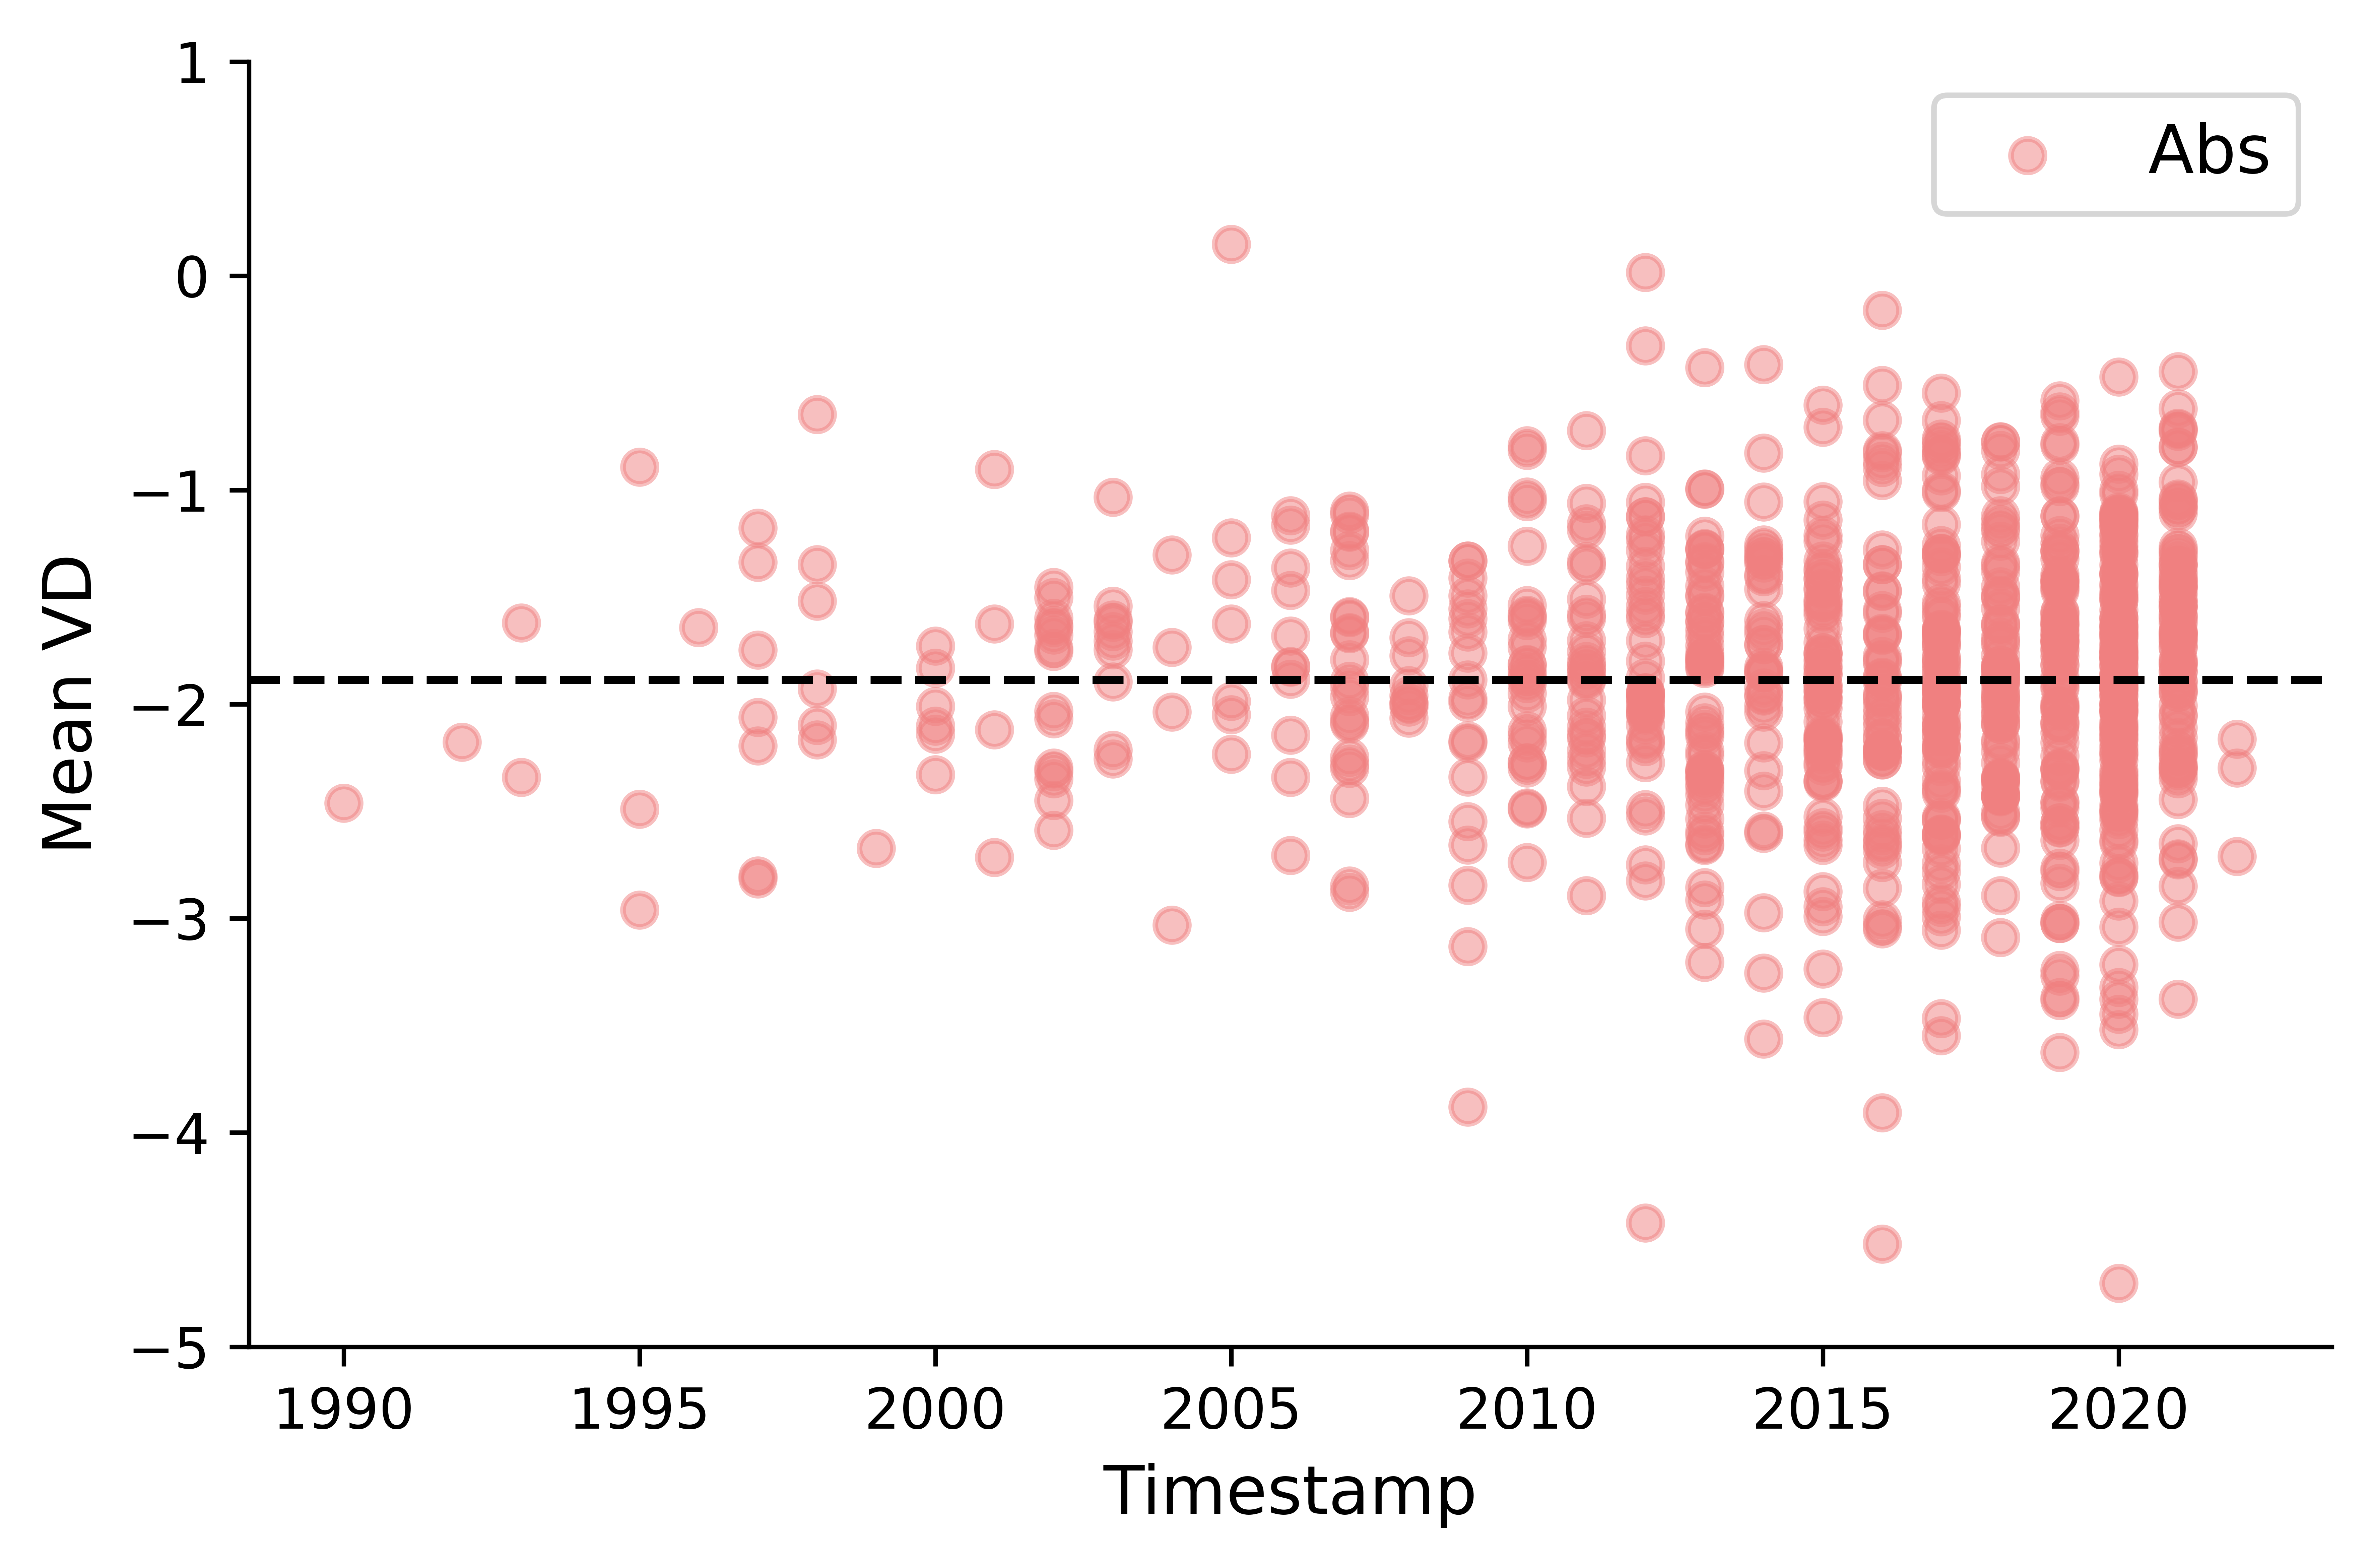

In [27]:
plot_results(abs_merge, abs_shapes['Mean VD'].describe()[1], 'lightcoral', 'Abs')

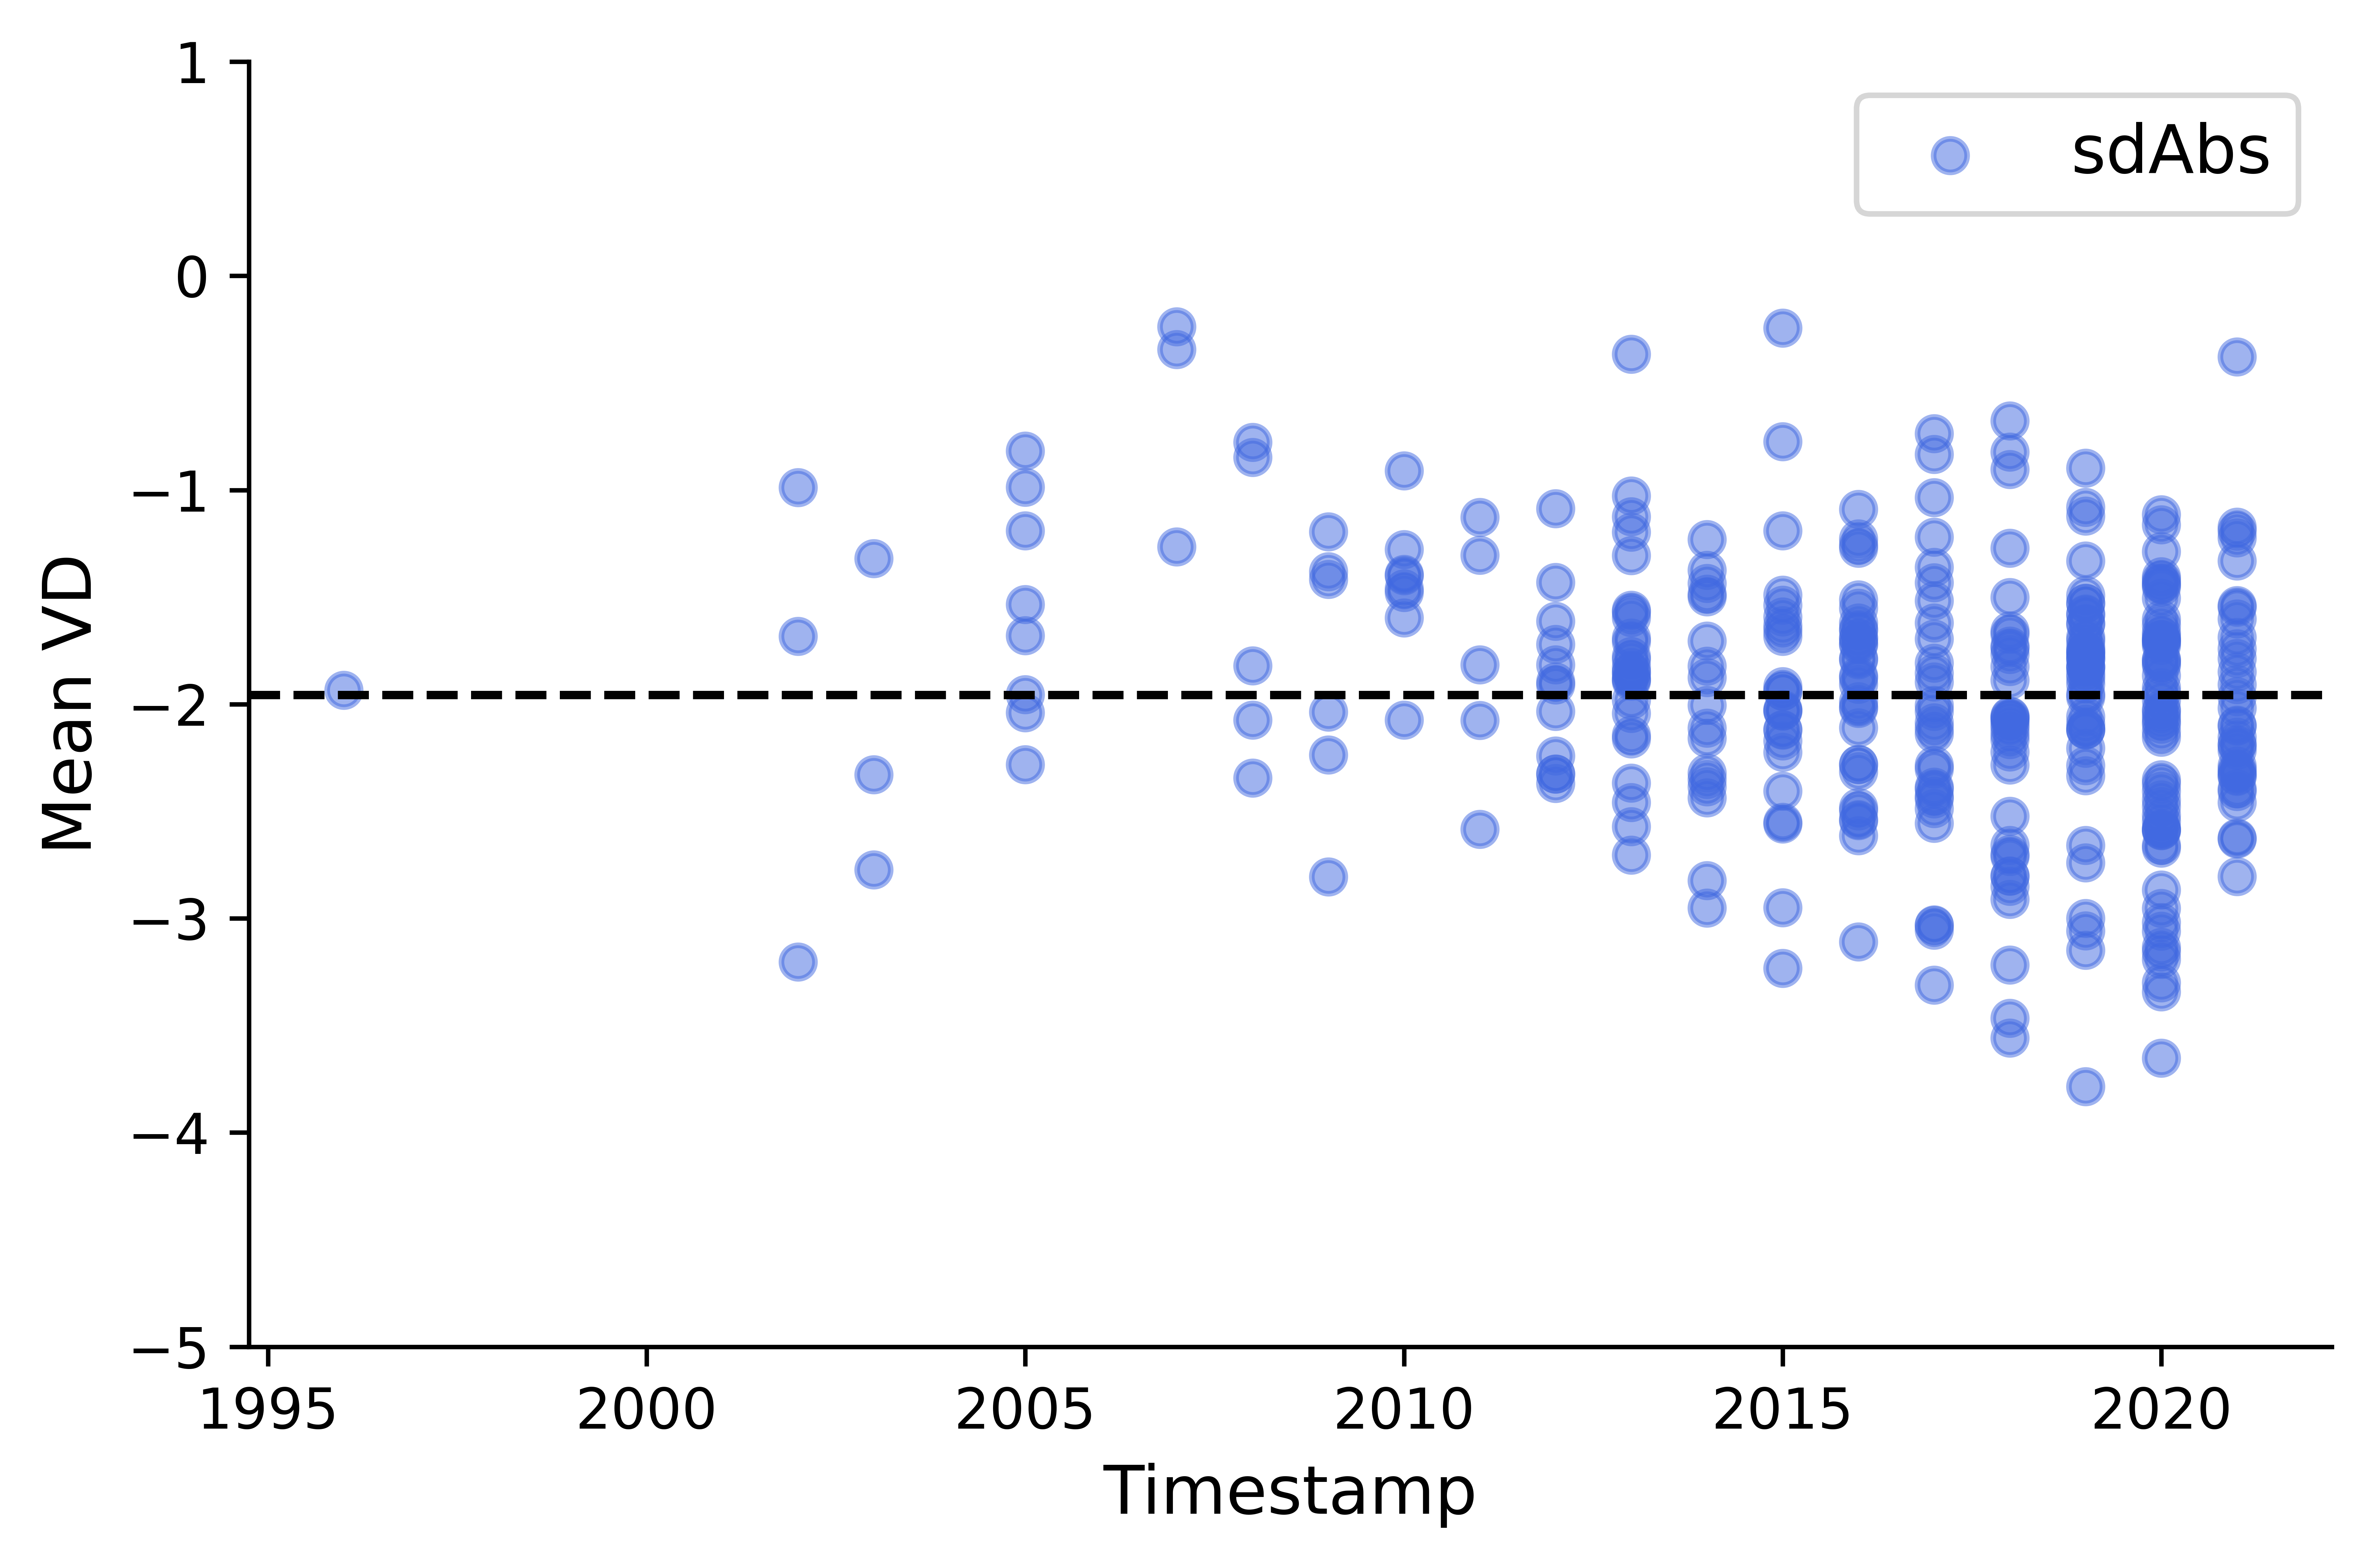

In [28]:
plot_results(sdabs_merge, sdabs_shapes['Mean VD'].describe()[1], 'royalblue', 'sdAbs')

Find and plot mean mean VD for each year

In [ ]:
from collections import defaultdict

In [ ]:
from collections import OrderedDict

In [ ]:
def plot_change_mean_VD(df, current_mean, colour, label):

    results_by_year = defaultdict(list) # create list of mean VDs in dict for each year
    for year, mean_vd in zip(df['Timestamp'], df['Mean VD']):
        results_by_year[year].append(mean_vd)

    # reorder by year 
    results_by_year = OrderedDict(sorted(results_by_year.items()))

    # get mean mean VD per year 
    years = []
    mean_mean_vds = []
    for year, mean_vds in results_by_year.items():
        years.append(year)
        mean_mean_vds.append(np.mean(mean_vds))

    plt.figure(figsize=(10,5))
    plt.scatter(years, mean_mean_vds, label=label, alpha=0.5, color=colour)
    plt.xticks(rotation=45)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean mean VD', fontsize=12)
    plt.ylim(-5, 1, 1)
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()

    # annotate with number of structures for that year
    for i, txt in enumerate([len(mean_vds) for mean_vds in results_by_year.values()]):
        plt.annotate(txt, (years[i], mean_mean_vds[i]))

    # plot current average from all structures
    plt.axhline(current_mean, color='black', linestyle='--')

    plt.show()

    return

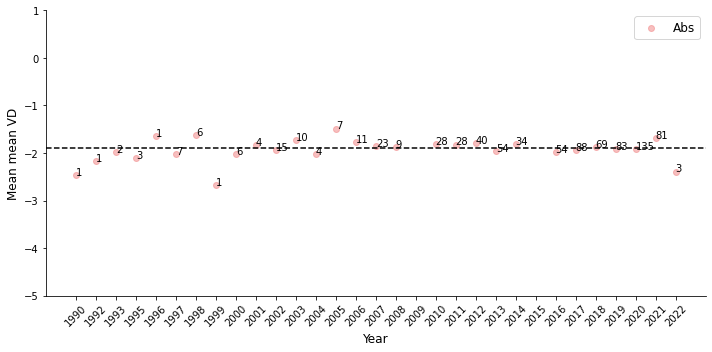

In [ ]:
plot_change_mean_VD(abs_merge, abs_shapes['Mean VD'].describe()[1], 'lightcoral', 'Abs')

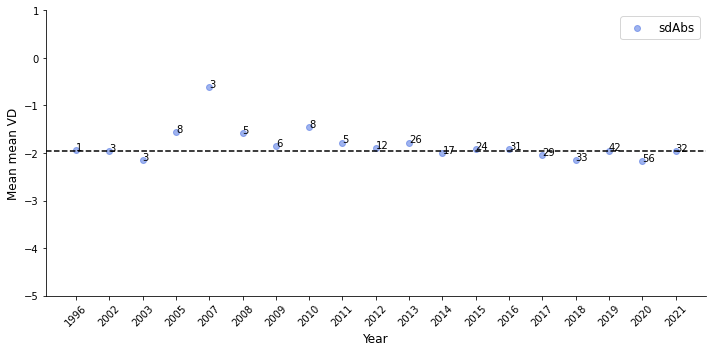

In [ ]:
plot_change_mean_VD(sdabs_merge, sdabs_shapes['Mean VD'].describe()[1], 'royalblue', 'sdAbs')